In [1]:
import numpy as np
import matplotlib.pyplot as plt
import distributions.priors as priors
import getdist
from getdist import plots, MCSamples
import ndes.ndes as ndes
import delfi.delfi as delfi
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
# Set up and load in data and simulations...

# Fiducial parameters about which data compression was performed
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])

# Set up the truncated Gaussian prior...

# Prior parameter boundaries
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])

# Prior mean and covariance
prior_mean = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
Q = np.eye(5)*np.array([0.1, 0.1, 0.05, 0.3, 0.3])**2

# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Import data summaries, simulated data summaries and corresponding parameters, and inverse Fisher matrix...

# NOTE: The compressed summaries should be in the form of pseudo maximum-likelihood parameter estimators
# ie, if you are using the score of an approximate log-likelihood L, you should use compressed summaries
# t = \theta_\mathrm{fiducial} + F^{-1}\nabla L where F is the approximate Fisher matrix

# Compressed data vector
data = np.genfromtxt('simulators/cosmic_shear/pre_ran_sims/compressed_data.dat')

# Parameters at which sims were ran
sim_params = np.genfromtxt('simulators/cosmic_shear/pre_ran_sims/simulations_parameters.dat')

# Compressed data for each simulation (corresponding to parameters above)
sim_data = np.genfromtxt('simulators/cosmic_shear/pre_ran_sims/simulations_compressed_data.dat')

# Inverse Fisher matrix: this can be a bit rough, no biggie
Finv = np.genfromtxt('simulators/cosmic_shear/pre_ran_sims/Finv.dat')

In [3]:
# Set up the Delfi object...

# Create the neural density estimator (MAF stands for Masked Autoregressive Flow)
# NOTE: n_inputs = number of parameters, n_outputs = number of compressed summaries
MAF = ndes.ConditionalMaskedAutoregressiveFlow(n_inputs=5, n_outputs=5, n_hiddens=[50,50], 
                                               n_mades=5, act_fun=tf.tanh)

# Create the DELFI object
DelfiMAF = delfi.Delfi(data, prior, MAF, Finv, theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s'], 
                       results_dir = "simulators/cosmic_shear/results_preran/maf")

# Load in the simulations
DelfiMAF.load_simulations(sim_data, sim_params)

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))

Sampling approximate posterior...
Done.


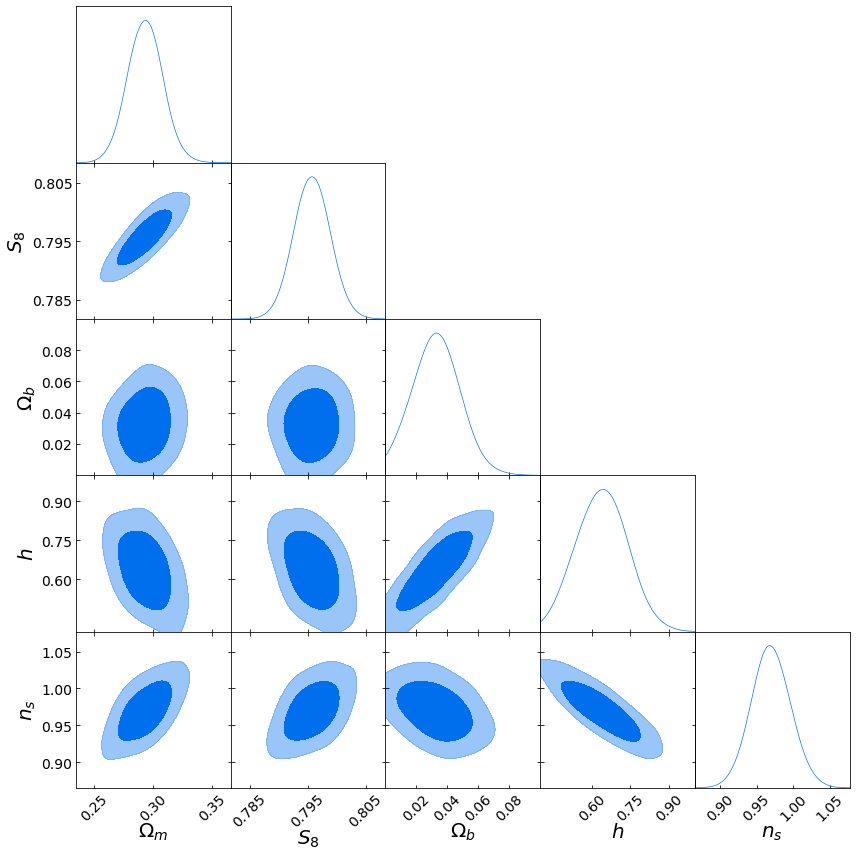

In [4]:
# Do the Fisher pre-training step to inirialize the network
DelfiMAF.fisher_pretraining(50000, prior, epochs=100, patience=10)

HBox(children=(IntProgress(value=0, description='Training', max=500), HTML(value='')))

Sampling approximate posterior...
Done.


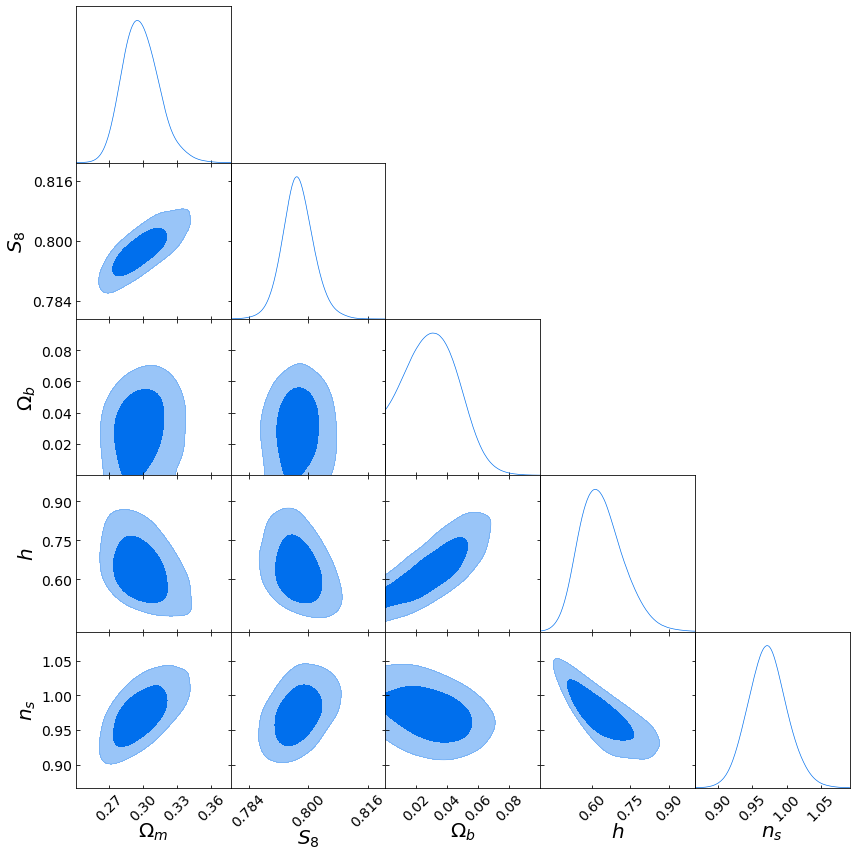

In [5]:
# Train the network
DelfiMAF.train(epochs=500, patience=20, batch_size=1000)

In [6]:
# Now let's do the same thing but with a Mixture Density Network instead of a MAF

# Create the neural density estimator (Masked Autoregressive Flow)
# NOTE: n_inputs = number of parameters, n_outputs = number of compressed summaries
# n_components = number of Gaussian components in the MDN (3-5 should be plenty)
MDN = ndes.MixtureDensityNetwork(n_inputs=5, n_outputs=5, n_components=3, 
                                 n_hidden=[50,50], activations=[tf.tanh, tf.tanh])

# Create the DELFI object
DelfiMDN = delfi.Delfi(data, prior, MDN, Finv, theta_fiducial, 
                       param_limits = [lower, upper],
                       param_names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s'], 
                       results_dir = "simulators/cosmic_shear/results_preran/mdn")

# Load in the simulations
DelfiMDN.load_simulations(sim_data, sim_params)

HBox(children=(IntProgress(value=0, description='Training', max=300), HTML(value='')))

Sampling approximate posterior...
Done.


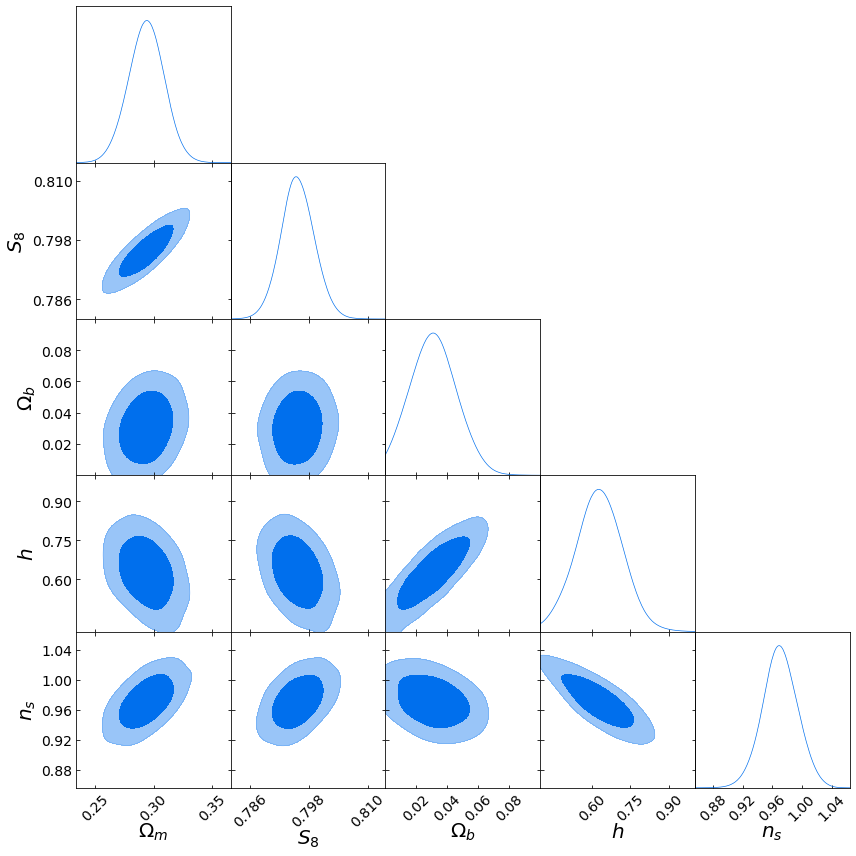

In [7]:
# Do the Fisher pre-training step to inirialize the network
DelfiMDN.fisher_pretraining()

HBox(children=(IntProgress(value=0, description='Training', max=500), HTML(value='')))

Sampling approximate posterior...
Done.


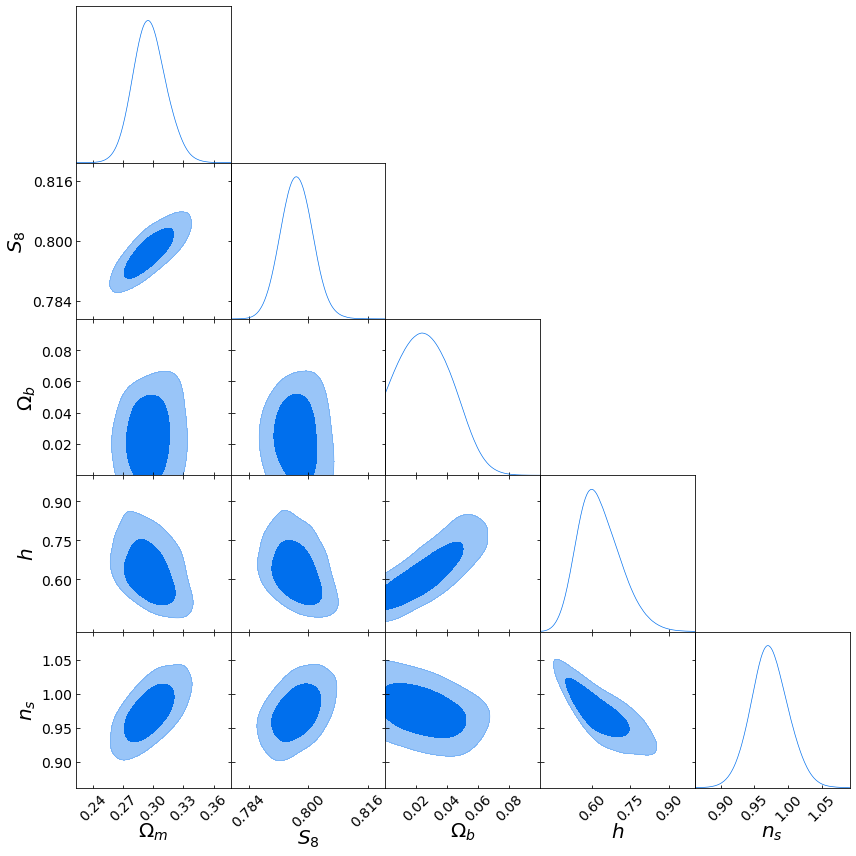

In [8]:
# Train the network
DelfiMDN.train(epochs=500, patience=20, batch_size=1000)

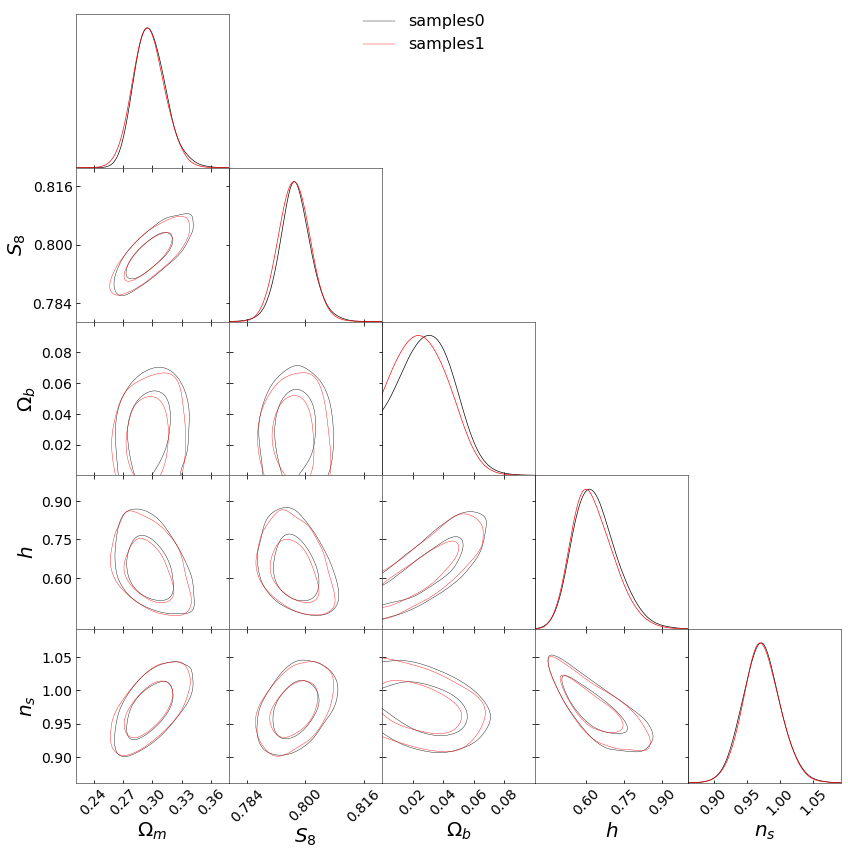

In [9]:
# Let's plot the MAF and MDN posteriors against eachother to check they give the same result

plt.close()
columnwidth = 40 # cm
aspect = 1.67*2
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 14,
                 'legend.fontsize': 'small',
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black'})


g = plots.getSubplotPlotter(width_inch = 12)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.6
g.settings.axes_fontsize=14
g.settings.legend_fontsize=16
g.settings.lab_fontsize=20

names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
labels = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
ranges = dict(zip(names, [ [lower[i], upper[i]] for i in range(len(names)) ]))

samples = [DelfiMAF.posterior_samples, DelfiMDN.posterior_samples]
mc_samples = [MCSamples(samples=s, names = names, labels = labels, ranges = ranges) for s in samples]

g.triangle_plot(mc_samples, normalized=True)

for i in range(0, len(names)):
    for j in range(0, i+1):
        ax = g.subplots[i,j]
        xtl = ax.get_xticklabels()
        ax.set_xticklabels(xtl, rotation=45)
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()